### This notebook plots sea surface height anomaly over the probability of beaching figure

In [27]:
# set working directory
import os
os.chdir('/dat1/openonic/Drifters')

In [28]:
# dependencies
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature


from tqdm import tqdm
import netCDF4 as nc

import scipy.interpolate as sci_int
import scipy.stats as sci_stats
import geopandas as gpd

from scipy.ndimage import gaussian_filter,  generic_filter

In [29]:
# set plotting text size parameters
plt.rcParams.update({
    'axes.titlesize': 30,
    'axes.labelsize': 24, 
    'xtick.labelsize': 18,  
    'ytick.labelsize': 18,  
    'legend.fontsize': 18, 
    'figure.titlesize': 28})

In [30]:
# load data
beach_undrogued = pd.read_csv('undrogued_beach.csv')
unbeach_undrogued = pd.read_csv('undrogued_unbeach.csv')
drogued = pd.read_csv('drogued.csv')

In [31]:
# load circulation data
os.chdir('/home/openonic/global-drifter-program/')

In [32]:
ssh = nc.Dataset('data/ssh.nc')
# Extract the 'adt' variable, and its coordinates
adt_data = ssh.variables['adt'][:]
adt_lons = ssh.variables['longitude'][:]
adt_lats = ssh.variables['latitude'][:]

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sy

In [33]:
adt_data_flat = np.array(adt_data).flatten()

# Create longitude and latitude arrays that match the shape of adt_data
lon_points = adt_data.shape[2]  # Number of longitude points
lat_points = adt_data.shape[1]  # Number of latitude points

# Generate latitudes and longitudes that correspond to the grid of adt_data
adt_lons = np.linspace(-180, 180, lon_points)
adt_lats = np.linspace(-90, 90, lat_points)

# Use meshgrid to create full latitude and longitude arrays for each grid point
adt_lons_grid, adt_lats_grid = np.meshgrid(adt_lons, adt_lats)

# Flatten the grids to match adt_data_flat
adt_lons_flat = adt_lons_grid.flatten()
adt_lats_flat = adt_lats_grid.flatten()

# Define binning parameters
n_lons, n_lats = 360, 180
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-95, 85, n_lats + 1) # adjustment for vertical shift error

# Compute binned statistics
adt_stat, x_edge, y_edge, binnumber = sci_stats.binned_statistic_2d(
    adt_lons_flat, adt_lats_flat, adt_data_flat,
    statistic='mean', bins=[lon_bins, lat_bins]
)

# Shift `adt_stat` to center Atlantic
adt_stat = np.roll(adt_stat, shift=adt_stat.shape[0] // 2, axis=0)

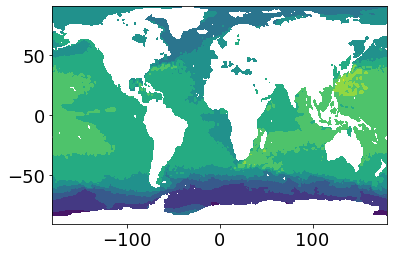

In [34]:
adt_stat_cont_remove = adt_stat.copy()
adt_stat_cont_remove[adt_stat < -2] = np.nan

# define desired rows and desired cols
desired_rows = 360
desired_cols = 180
# define lat and lon
lats = np.linspace(-90,90,desired_cols)
lons = np.linspace(-180, 180, desired_rows)
plt.contourf(lons, lats, adt_stat_cont_remove.T)

In [35]:
# probability of beaching:

In [36]:
# we follow the steps in the probability of beaching notebook:
def probability_of_beaching(beached_count, unbeached_count):
    probability = beached_count / (beached_count + unbeached_count)
    return probability

# get beached lats and lons
beach_undrogued_lats = np.array(beach_undrogued['lat'])
beach_undrogued_longs = np.array(beach_undrogued['lon'])

# get unbeached lats and lons
unbeach_undrogued_lats = np.array(unbeach_undrogued['lat'])
unbeach_undrogued_longs = np.array(unbeach_undrogued['lon'])

# let's use sci_stats.binned_statistic_2d to bin by lat/lon and count

# beached
n_lons, n_lats = 360, 180 # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

beach_undrogued_stat, x_edge, y_edge, binnumber = sci_stats.binned_statistic_2d(
    beach_undrogued_longs,beach_undrogued_lats,values=beach_undrogued['id'],
    statistic = 'count', bins = [lon_bins,lat_bins])

# unbeached
n_lons, n_lats = 360, 180 # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

unbeach_undrogued_stat, x_edge, y_edge, binnumber = sci_stats.binned_statistic_2d(
    unbeach_undrogued_longs,unbeach_undrogued_lats,values=unbeach_undrogued['id'],
    statistic = 'count', bins = [lon_bins,lat_bins])

probability_undrogued = probability_of_beaching(beach_undrogued_stat, unbeach_undrogued_stat).T

# put into 'beach_prob' dataframe and remove data past -70 and 70 degrees lat:
beach_prob = pd.DataFrame(probability_undrogued)#.iloc[30:-30]
beach_prob_vals = beach_prob.values

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [37]:
# guassian filter both probability of beaching and ssh
def nan_gaussian_filter(values, sigma):
    mask = np.isnan(values)
    values_filled = np.where(mask, np.nanmean(values), values)  # Replace NaNs with the mean of non-NaNs
    filtered = gaussian_filter(values_filled, sigma=sigma)
    filtered[mask] = np.nan  # Restore NaNs
    return filtered

# apply filter
beach_prob_vals_filtered = nan_gaussian_filter(beach_prob_vals, sigma=1.4)
adt_stat_filtered = nan_gaussian_filter(adt_stat_cont_remove, sigma=2)

In [38]:
# define desired rows and desired cols
desired_rows = 360
desired_cols = 180
# define lat and lon
lats = np.linspace(-90,90,desired_cols)
lons = np.linspace(-180, 180, desired_rows)

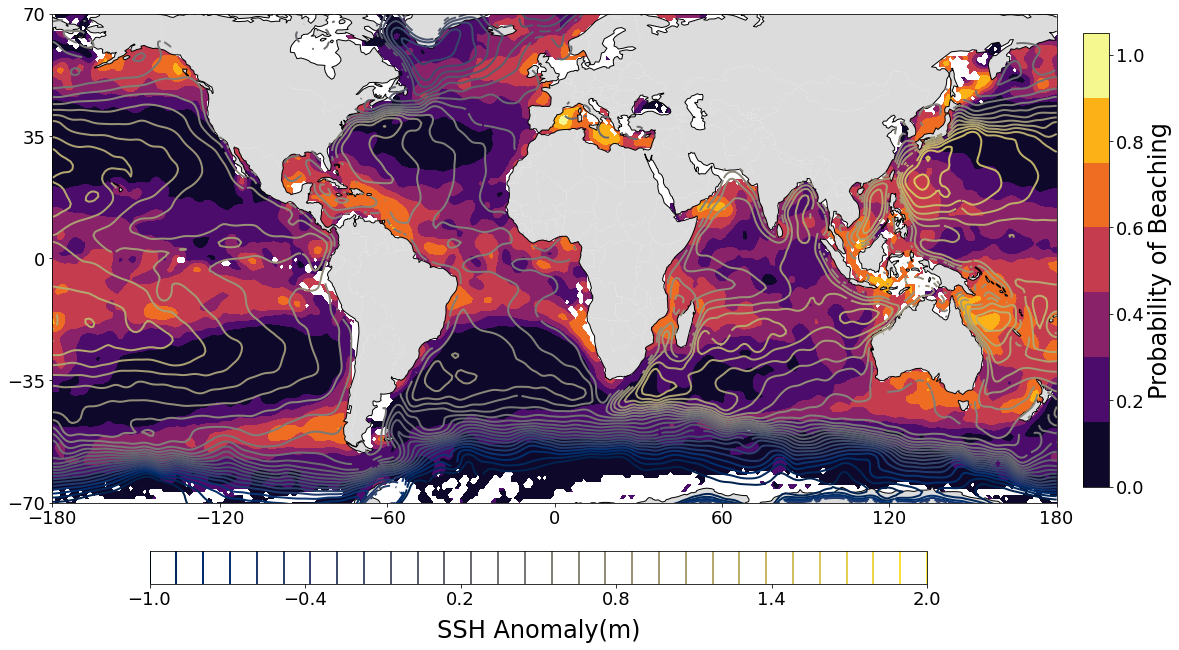

In [70]:
# Load world shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
land = world[world['continent'] != 'Antarctica']
Antarctica = world[world['continent'] == 'Antarctica']

# visualize probability of beaching
fig, ax1 = plt.subplots(1, 1, figsize=(18, 9),
                          subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})
ax1.set_xticks([-180, -120, -60, 0, 60, 120, 180])
ax1.set_yticks([-70, -35, 0, 35, 70])

cmap = plt.get_cmap('inferno').copy()
im1 = ax1.contourf(lons, lats, beach_prob_vals_filtered, cmap=cmap, 
                   transform=ccrs.PlateCarree(), vmin=0, vmax=1.0, levels=6)

ax1.set_extent([-180, 180, -70, 70], crs=ccrs.PlateCarree())

land.plot(ax=ax1, color='gainsboro', edgecolor='none')
Antarctica.plot(ax=ax1, color='gainsboro', edgecolor='none')
ax1.coastlines(color='black')
ax1.set_aspect('auto')

# colorbar for probability of beaching
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(im1, cax=cbar_ax, label='Probability of Beaching')
cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
im1.set_clim(0, 1.0)  # Sets the color limits for the ScalarMappable

# plot ssh contours
contour_levels = np.linspace(-1,2,30)#[-0.25, 0, 0.25, 0.5, 0.75, 1, 1.25, 1.5,1.7,1.8]
contour = ax1.contour(lons, lats, adt_stat_filtered.T, levels=contour_levels,
            cmap = 'cividis', linewidths = 2, vmin = -1, vmax = 2)

# colorbar for ssh
cbar_ax = fig.add_axes([0.2, 0, 0.6, 0.05])  # [left, bottom, width, height]
cbar = fig.colorbar(contour, cax=cbar_ax, orientation='horizontal')
cbar.set_label('SSH Anomaly(m)', labelpad=10)
cbar.set_ticks(np.linspace(-1,2, 6))
#contour.set_clim(-0.9,1.9)  # Sets the color limits for the ScalarMappable


#plt.savefig('prob_beach_ssh.png', dpi=300)
plt.show()